# Label all GBH news articles using embedding similarity
Created annd maintained by Dingyuan Xu dyxu@bu.edu

In [17]:
import pandas as pd
import numpy as np
import json
import openai
import tiktoken
from bs4 import BeautifulSoup
import re
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity

### This is an attempt to remove BERTopic from the pipeline and test model prediction on pure embedding similarity-based approach. 

In [3]:
# Independent cell to define embedding function

openai.api_key =  # GitHub version does not include the OpenAI API key, please replace with your own key

import openai
from tenacity import retry, wait_random_exponential, stop_after_attempt

# Retry up to 6 times with exponential backoff, starting at 1 second and maxing out at 20 seconds delay
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(6))
def get_embedding(text: str, model='text-embedding-3-small') -> list[float]:
    # print(text)
    return openai.Embedding.create(input=text, model=model)["data"][0]["embedding"]

In [10]:
# Load GBH articles
unseen_articles = pd.read_csv('../datasets/labels_for_review.csv')
# unseen_articles = pd.read_csv('../datasets/Articles Nov 2020 - March 2023.csv', usecols=range(12))
# unseen_articles = unseen_articles.dropna(subset=['Body'])
# unseen_articles = unseen_articles.sample(n=5000, random_state=1)
unseen_articles.reset_index(drop=True, inplace=True)
print(unseen_articles.head(3))

   Unnamed: 0                        ID  \
0         459  65aee8c98d9d92f2327eaacb   
1         296  65aeb9b68d9d92f2327eaa27   
2         210  65aeb9b68d9d92f2327ea9d1   

                                              Header  \
0  Breaking down the NBA's in-season tournament w...   
1  Healey anticipates ‘hard calls’ as emergency s...   
2  Faced with a lack of funding, collegiate cheer...   

                                                Body  \
0  Jeremy Siegel: This is GBH's Morning Edition. ...   
1  Gov. Maura Healey says she’s bracing to make t...   
2  For 10 Sundays each year, members of the Bridg...   

  OpenAI Labels (Embed Model) [closest_topic_selected]  \
0                                Sports - Basketball     
1  Personal Finance - Financial Assistance - Gove...     
2                              Sports - Cheerleading     

     OpenAI Labels (Embed Model) [closest_topic_all] Predicted Singer Labels  \
0                                Sports - Basketball            

In [ ]:
# News body preprocessing, gets rid of html tags
from bs4 import BeautifulSoup
import re
# Function to get the first 500 elements from a list
def truncate(tokens, length=500):
    return tokens[:length]

unseen_articles['Body'] = unseen_articles['Body'].apply(lambda x: re.sub(re.compile('<.*?>'), '', x))
unseen_articles['tokens'] = unseen_articles['Body'].apply(lambda x: x.split())
unseen_articles['tokens'] = unseen_articles['tokens'].apply(truncate)

print(max(len(row['tokens']) for _, row in unseen_articles.iterrows()))

unseen_articles['ada_embedding'] = unseen_articles.tokens.apply(lambda x: get_embedding(','.join(map(str,x)), model='text-embedding-ada-002'))

print(unseen_articles.head(5))

In [11]:
# Experimenting with the new embedding model
# Updated token count & truncating preprocessing, using OpenAI's tiktoken

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def truncate_to_max_tokens(string: str, encoding_name: str, max_tokens: int = 8192) -> str:
    """Truncate the string to not exceed max_tokens when encoded."""
    # Initially assume the full string is okay
    end = len(string)
    start = 0
    while start < end:
        # Check the middle of the current text portion
        mid = (start + end) // 2
        current_slice = string[:mid]
        tokens_count = num_tokens_from_string(current_slice, encoding_name)
        
        if tokens_count > max_tokens:
            # Too many tokens, need to reduce the size of the text
            end = mid - 1
        else:
            # Not too many tokens, but can we include more?
            if tokens_count == max_tokens or num_tokens_from_string(string[:mid + 1], encoding_name) > max_tokens:
                return current_slice
            else:
                start = mid + 1

    # In case the string is shorter than the max tokens or exactly max tokens, return the original string
    return string

encoding_name = "cl100k_base"
# original_text = "Your very long text here..."
# truncated_text = truncate_to_max_tokens(original_text, encoding_name, 8192)
# print(f"Truncated text to ensure it doesn't exceed 8192 tokens: {truncated_text}")

unseen_articles['Body'] = unseen_articles['Body'].apply(lambda x: re.sub(re.compile('<.*?>'), '', x))
unseen_articles['processed_body'] = unseen_articles['Body'].apply(lambda x: truncate_to_max_tokens(x, "cl100k_base", 8192))
unseen_articles = unseen_articles.dropna(subset=['processed_body'])
unseen_articles['ada_embedding'] = unseen_articles['processed_body'].apply(lambda x: get_embedding(x))

print(unseen_articles.head(3))

   Unnamed: 0                        ID  \
0         459  65aee8c98d9d92f2327eaacb   
1         296  65aeb9b68d9d92f2327eaa27   
2         210  65aeb9b68d9d92f2327ea9d1   

                                              Header  \
0  Breaking down the NBA's in-season tournament w...   
1  Healey anticipates ‘hard calls’ as emergency s...   
2  Faced with a lack of funding, collegiate cheer...   

                                                Body  \
0  Jeremy Siegel: This is GBH's Morning Edition. ...   
1  Gov. Maura Healey says she’s bracing to make t...   
2  For 10 Sundays each year, members of the Bridg...   

  OpenAI Labels (Embed Model) [closest_topic_selected]  \
0                                Sports - Basketball     
1  Personal Finance - Financial Assistance - Gove...     
2                              Sports - Cheerleading     

     OpenAI Labels (Embed Model) [closest_topic_all] Predicted Singer Labels  \
0                                Sports - Basketball            

In [27]:
# Get the embedding for taxonomy
taxonomy_df = pd.read_csv('../datasets/Content_Taxonomy.csv', skiprows=5, usecols=range(8))
taxonomy_df.columns = taxonomy_df.iloc[0]
taxonomy_df = taxonomy_df.tail(-1)

tier_1_list = []
tier_2_list = []
tier_3_list = []
tier_4_list = []
for index, row in taxonomy_df.iterrows():
    if not pd.isnull(row['Tier 4']) and row['Tier 4'] != ' ':
        tier_1_label = row['Tier 1']
        tier_2_label = row['Tier 2']
        tier_3_label = row['Tier 3']
        tier_4_label = row['Tier 4']
        tier_4_list.append(f'{tier_1_label} - {tier_2_label} - {tier_3_label} - {tier_4_label}')
    elif not pd.isnull(row['Tier 3']) and row['Tier 3'] != ' ':
        tier_1_label = row['Tier 1']
        tier_2_label = row['Tier 2']
        tier_3_label = row['Tier 3']
        tier_3_list.append(f'{tier_1_label} - {tier_2_label} - {tier_3_label}')
    elif not pd.isnull(row['Tier 2']) and row['Tier 2'] != ' ':
        tier_1_label = row['Tier 1']
        tier_2_label = row['Tier 2']
        tier_2_list.append(f'{tier_1_label} - {tier_2_label}')
    else:
        tier_1_label = row['Tier 1']
        tier_1_list.append(f'{tier_1_label}')

tier_1_list = list(set(tier_1_list))
tier_2_list = list(set(tier_2_list))
tier_3_list = list(set(tier_3_list))
tier_4_list = list(set(tier_4_list))

tier_1_embedding = [get_embedding(topic) for topic in tier_1_list]
tier_2_embedding = [get_embedding(topic) for topic in tier_2_list]
tier_3_embedding = [get_embedding(topic) for topic in tier_3_list]
tier_4_embedding = [get_embedding(topic) for topic in tier_4_list]

all_topics_list = []
[all_topics_list.append(topic) for topic in tier_1_list]
[all_topics_list.append(topic) for topic in tier_2_list]
[all_topics_list.append(topic) for topic in tier_3_list]
[all_topics_list.append(topic) for topic in tier_4_list]

all_topics_embedding = []
[all_topics_embedding.append(embedding) for embedding in tier_1_embedding]
[all_topics_embedding.append(embedding) for embedding in tier_2_embedding]
[all_topics_embedding.append(embedding) for embedding in tier_3_embedding]
[all_topics_embedding.append(embedding) for embedding in tier_4_embedding]
print(len(all_topics_embedding))

703


In [28]:
# Get embedding for the 230 topics selected by BERTopic 
selected_taxonomy_df = pd.read_csv('../openai_label_file/embedding_similarity_label.csv')
selected_taxonomy_df = selected_taxonomy_df.dropna(subset=['closest_topic'])
selected_topics_list = selected_taxonomy_df['closest_topic'].values.tolist()
# print(all_topics_list)

selected_topics_embedding = [get_embedding(topic) for topic in selected_topics_list]

In [59]:
# Alternative taxonomy: client's list of topics
client_taxonomy_df = pd.read_excel('../datasets/singers_topics_list.xlsx', names=['label'])
client_taxonomy_df['ada_embedding'] = client_taxonomy_df['label'].map(get_embedding)

In [60]:
client_taxonomy_df

,label,ada_embedding
0,Addiction/Substance Use,"[-0.061630979180336, 0.0022212022449821234, -0..."
1,Aging/Seniors,"[0.019805988296866417, -0.020345032215118408, ..."
2,Agriculture,"[0.004109605681151152, 0.008446525782346725, 0..."
3,Arts & Culture,"[0.0010271111968904734, 0.009806315414607525, ..."
4,City Council,"[-0.018766839057207108, 0.009444482624530792, ..."
...,...,...
68,Transportation,"[0.00529756722971797, -0.016359109431505203, -..."
69,Travel/Tourism,"[-0.0044678570702672005, -0.003228220622986555..."
70,Veterans Affairs,"[-0.023391159251332283, -0.001010976848192513,..."
71,Weather,"[-0.03212082013487816, 0.01414079125970602, -0..."


In [14]:
asad_taxonomy_df = pd.read_csv('../datasets/asad_topic_list.csv', names=['label'])
asad_taxonomy_df['ada_embedding'] = asad_taxonomy_df['label'].map(get_embedding)

In [15]:
asad_taxonomy_df

,label,ada_embedding
0,Abortion,"[0.027180315926671028, 0.03709282726049423, 0...."
1,Accessiblity/Disablity,"[0.015572784468531609, 0.013858539052307606, 0..."
2,Addiction/Substance Use,"[-0.061630979180336, 0.0022212022449821234, -0..."
3,Aging/Seniors,"[0.019839337095618248, -0.02033223956823349, 0..."
4,Agriculture,"[0.004109605681151152, 0.008446525782346725, 0..."
5,Arts & Culture,"[0.0010271111968904734, 0.009806315414607525, ..."
6,Local Politics,"[-0.0332532562315464, -0.005176577251404524, 0..."
7,Business & Finance,"[-0.03726862743496895, 0.02918992005288601, 0...."
8,Childcare,"[0.013896326534450054, 0.012883052229881287, 0..."
9,Civil Rights,"[0.07797594368457794, 0.025917718186974525, 0...."


In [29]:
# Find most similar taxonomy (out of all toipcs) to news body

import numpy as np

closest_topic_list_all = []
for index, row in unseen_articles.iterrows():
    target_embedding = row['ada_embedding']
    similarities = [cosine_similarity(np.array(target_embedding).reshape(1, -1), np.array(topic).reshape(1, -1))[0][0] for topic in all_topics_embedding]

    # Find the index of the topic with the highest similarity
    closest_topic_index = np.argmax(similarities)

    # Retrieve the closest topic embedding
    closest_topic = all_topics_list[closest_topic_index]
    closest_topic_list_all.append(closest_topic)

unseen_articles['closest_topic_all'] = closest_topic_list_all
print(unseen_articles.head(3))

      Type                                              Label  \
0  Article  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Article  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Article  Infrastructure bills are kicking off billions ...   
3  Article  David Prowse, Actor Behind Darth Vader, Dies A...   
4  Article  President Trump Invites Michigan GOP Leaders T...   
5  Article  Japan Society Of Boston Marks Ten Years Since ...   
6  Article  U.S. Soccer paying millions in back pay to fem...   
7  Article  In living color: The Obama portraits come to B...   
8  Article  Arts This Week: A Public Art Exhibit On The Co...   
9  Article  RadRunner Plus Electric Bike 89.7 Sweepstakes ...   

                                            Headline  \
0  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Infrastructure bills are kicking off billions ...   
3  David Prowse, Actor Behind Darth Vader, Dies A...   
4  P

In [30]:
# Find most similar taxonomy (out of 230 selected topics) to news body
closest_topic_list_selected = []
for index, row in unseen_articles.iterrows():
    target_embedding = row['ada_embedding']
    similarities = [cosine_similarity(np.array(target_embedding).reshape(1, -1), np.array(topic).reshape(1, -1))[0][0] for topic in selected_topics_embedding]

    # Find the indices of the top 3 topics with the highest similarity
    # closest_topic_index = np.argmax(similarities)
    top3_indices = np.argsort(similarities)[-3:][::-1]  # This reverses the slice to ensure highest similarities are first

    # Retrieve the closest topic embedding
    # closest_topic = selected_topics_list[closest_topic_index]
    # closest_topic_list_selected.append(closest_topic)
    top3_topics = [selected_topics_list[index] for index in top3_indices]
    closest_topics_list_selected.append(top3_topics)

unseen_articles['closest_topic_selected'] = closest_topic_list_selected
print(unseen_articles.head(3))

      Type                                              Label  \
0  Article  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Article  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Article  Infrastructure bills are kicking off billions ...   
3  Article  David Prowse, Actor Behind Darth Vader, Dies A...   
4  Article  President Trump Invites Michigan GOP Leaders T...   
5  Article  Japan Society Of Boston Marks Ten Years Since ...   
6  Article  U.S. Soccer paying millions in back pay to fem...   
7  Article  In living color: The Obama portraits come to B...   
8  Article  Arts This Week: A Public Art Exhibit On The Co...   
9  Article  RadRunner Plus Electric Bike 89.7 Sweepstakes ...   

                                            Headline  \
0  'Atlantic Crossing' Episode 3 Recap: Happy Day...   
1  Pharaoh of the opera: Anthony Roth Costanzo di...   
2  Infrastructure bills are kicking off billions ...   
3  David Prowse, Actor Behind Darth Vader, Dies A...   
4  P

In [1]:
# Find most similar taxonomy (out of client's list of topics) to news body

# Column of embeddings to list

client_topic_embedding_list = client_taxonomy_df['ada_embedding'].to_list()
client_topic_embedding_list = client_taxonomy_df['ada_embedding'].to_list()
client_topic_list = client_taxonomy_df['label'].to_list()
similarity_arr = []

closest_topic_list_client = []
for index, row in unseen_articles.iterrows():
    target_embedding = row['ada_embedding']
    similarities = [cosine_similarity(np.array(target_embedding).reshape(1, -1), np.array(topic).reshape(1, -1))[0][0] for topic in client_topic_embedding_list]
    
    if max(similarities) > 0.2:    
        # Find the index of the topic with the highest similarity
        # closest_topic_index = np.argmax(similarities)
        top3_indices = np.argsort(similarities)[-3:][::-1]  # This reverses the slice to ensure highest similarities are first

        # Retrieve the closest topic embedding
        # closest_topic = client_topic_list[closest_topic_index]
        # closest_topic_list_client.append(closest_topic)
        top3_topics = [client_topic_list[index] for index in top3_indices]
        closest_topic_list_client.append(top3_topics)

    else:
        closest_topic_list_client.append('Other')
    similarity_arr.append(max(similarities))
    
unseen_articles['closest_topic_client'] = closest_topic_list_client
print(unseen_articles.head(10))

NameError: name 'client_taxonomy_df' is not defined

In [22]:
# Find most similar taxonomy (out of asad's list of topics) to news body

# Column of embeddings to list

asad_topic_embedding_list = asad_taxonomy_df['ada_embedding'].to_list()
asad_topic_embedding_list = asad_taxonomy_df['ada_embedding'].to_list()
asad_topic_list = asad_taxonomy_df['label'].to_list()
similarity_arr = []

closest_topic_list_asad = []
for index, row in unseen_articles.iterrows():
    target_embedding = row['ada_embedding']
    similarities = [cosine_similarity(np.array(target_embedding).reshape(1, -1), np.array(topic).reshape(1, -1))[0][0] for topic in asad_topic_embedding_list]
    
    if max(similarities) > 0:    
        # Find the index of the topic with the highest similarity
        # closest_topic_index = np.argmax(similarities)
        top3_indices = np.argsort(similarities)[-3:][::-1]  # This reverses the slice to ensure highest similarities are first

        # Retrieve the closest topic embedding
        # closest_topic = client_topic_list[closest_topic_index]
        # closest_topic_list_client.append(closest_topic)
        top3_topics = [asad_topic_list[index] for index in top3_indices]
        closest_topic_list_asad.append(top3_topics)

    else:
        closest_topic_list_asad.append('Other')
    similarity_arr.append(max(similarities))
    
unseen_articles['Asad Label'] = closest_topic_list_asad
print(unseen_articles.head(3))

   Unnamed: 0                        ID  \
0         459  65aee8c98d9d92f2327eaacb   
1         296  65aeb9b68d9d92f2327eaa27   
2         210  65aeb9b68d9d92f2327ea9d1   

                                              Header  \
0  Breaking down the NBA's in-season tournament w...   
1  Healey anticipates ‘hard calls’ as emergency s...   
2  Faced with a lack of funding, collegiate cheer...   

                                                Body  \
0  Jeremy Siegel: This is GBH's Morning Edition. ...   
1  Gov. Maura Healey says she’s bracing to make t...   
2  For 10 Sundays each year, members of the Bridg...   

  OpenAI Labels (Embed Model) [closest_topic_selected]  \
0                                Sports - Basketball     
1  Personal Finance - Financial Assistance - Gove...     
2                              Sports - Cheerleading     

     OpenAI Labels (Embed Model) [closest_topic_all] Predicted Singer Labels  \
0                                Sports - Basketball            

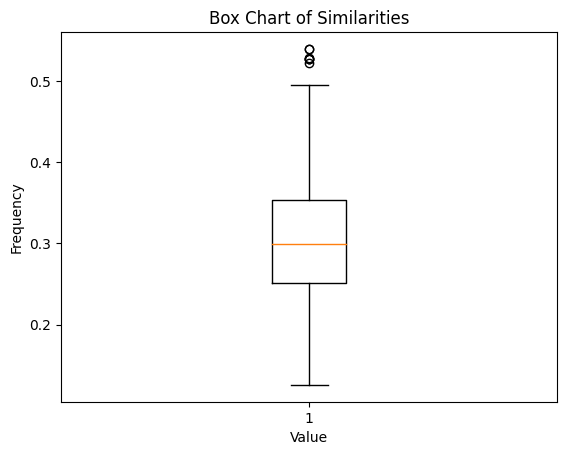

In [23]:
import matplotlib.pyplot as plt

plt.boxplot(similarity_arr)
plt.title('Box Chart of Similarities')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [24]:
# unseen_articles.to_csv('../output/pure_embedding_all_gbh_5000.csv', columns=['Headline', 'Section', 'Body', 'closest_topic_all', 'closest_topic_selected', 'closest_topic_client'])
# Outputs all columns but ada_embedding
columns_to_output = unseen_articles.columns.difference(['ada_embedding', 'Unnamed: 0', 'processed_body'])
unseen_articles.to_csv('../output/pure_embedding_three_labels_singer.csv', columns=columns_to_output)